# install required libraries

## NOTE: This environment has been installed basic libraries like as torch, jupyter, pandas, numpy, and so on. 

In [76]:
!pip3 install opendatasets transformers pandas-profiling -q

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# prepare data files and authorize kaggle

import opendatasets as od

od.download('https://www.kaggle.com/c/nlp-getting-started', force=True)

!cp ./nlp-getting-started/* .

# load data files

In [77]:
import pandas as pd
import numpy as np
import torch

sample_df = pd.read_csv('sample_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

sample_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


# preprocess

In [78]:
from transformers import BertForSequenceClassification, BertTokenizer

In [79]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [80]:
train_sentences = train_df['text'].values
train_labels = train_df['target'].values
test_sentences = test_df['text'].values

## show frequency of each sentence

(array([  85.,  296.,  445.,  551.,  779.,  973.,  961., 1032., 2334.,
         157.]),
 array([  7.,  22.,  37.,  52.,  67.,  82.,  97., 112., 127., 142., 157.]),
 <BarContainer object of 10 artists>)

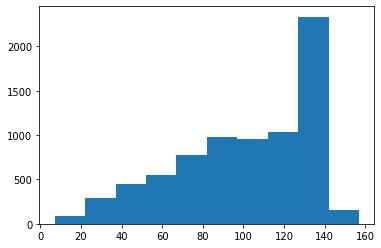

In [81]:
import matplotlib.pyplot as plt

plt.hist([len(sentence) for sentence in train_sentences])

(array([ 35., 111., 153., 218., 272., 408., 388., 386., 755., 537.]),
 array([  5. ,  19.6,  34.2,  48.8,  63.4,  78. ,  92.6, 107.2, 121.8,
        136.4, 151. ]),
 <BarContainer object of 10 artists>)

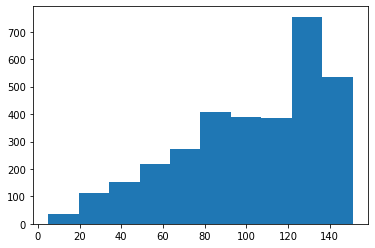

In [82]:
plt.hist([len(sentence) for sentence in test_sentences])

# tokenize

In [83]:
max_length = max([len(sentence) for sentence in np.concatenate([train_sentences, test_sentences], axis=0)])
max_length = 180

In [84]:
def encode_sentences(sentences, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encode_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encode_dict['input_ids'])
        attention_masks.append(encode_dict['attention_mask'])
        
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [85]:
train_input_ids, train_attention_masks = encode_sentences(train_sentences, max_length)

In [86]:
train_labels = torch.tensor(train_labels)

# set dataset and dataloader for train

In [87]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [88]:
dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

In [89]:
train_size = int(len(dataset) * 0.99)
val_size = len(dataset) - train_size

In [90]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [91]:
batch_size = 16

train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)
val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

# set pretrained model

In [92]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# set optimizer

In [93]:
from transformers import AdamW

In [94]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# set learning rate scheduler

In [95]:
from transformers import get_linear_schedule_with_warmup

In [96]:
epochs = 1
total_step = len(train_dataset) * epochs

In [97]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_step
)

In [98]:
def get_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(preds_flat == labels_flat) / len(preds_flat)

In [99]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [100]:
training_stats = []

total_t0 = time.time()
previous_val_loss = 0

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = output[0]
        logits = output[1]
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)          
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            output = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels)
            loss = output[0]
            logits = output[1]
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += get_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
    if epoch_i == 0:
        previous_val_loss = avg_val_loss
    else:
        if previous_val_loss <= avg_val_loss:
            break

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    40  of    471.    Elapsed: 0:00:03.
  Batch    80  of    471.    Elapsed: 0:00:05.
  Batch   120  of    471.    Elapsed: 0:00:08.
  Batch   160  of    471.    Elapsed: 0:00:10.
  Batch   200  of    471.    Elapsed: 0:00:13.
  Batch   240  of    471.    Elapsed: 0:00:15.
  Batch   280  of    471.    Elapsed: 0:00:18.
  Batch   320  of    471.    Elapsed: 0:00:20.
  Batch   360  of    471.    Elapsed: 0:00:23.
  Batch   400  of    471.    Elapsed: 0:00:25.
  Batch   440  of    471.    Elapsed: 0:00:28.

  Average training loss: 0.44
  Training epcoh took: 0:00:30

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.40
  Validation took: 0:00:00

Training complete!
Total training took 0:00:30 (h:mm:ss)


In [101]:
test_input_ids, test_attention_masks = encode_sentences(test_sentences, max_length)

In [102]:
test_labels = torch.tensor(np.ones(len(test_input_ids)))

In [103]:
predict_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
predict_dataloader = DataLoader(predict_data, sampler=SequentialSampler(predict_data), batch_size=batch_size)

In [104]:
model.eval()

predictions = []

for batch in predict_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_attention_masks, b_labels = batch    

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_masks, token_type_ids=None)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    pred_flatten = np.argmax(logits,axis=1).flatten()

    label_ids = b_labels.to('cpu').numpy()
    label_ids = label_ids.flatten()
    
    predictions.extend(pred_flatten)

# calculate accuracy

In [105]:
correct_df = pd.read_csv('submission.csv')

In [106]:
correct_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [107]:
correct_df[correct_df['target'].values == predictions].shape[0] / correct_df.shape[0]

0.8443150475022985

# save submission file and submit predictions 

import csv

with open('submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target'])
    for idx, target in zip(test_df['id'].values, predictions):
        writer.writerow([idx, target])

#!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "My third try"

import pandas_profiling